In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import feature_column
from tensorflow.keras.layers import Embedding, Input, Dot, Dense, Flatten, Multiply, Concatenate, DenseFeatures
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
import datetime

# Preprocess data

In [2]:
def preprocess_data(data_path):
    header_data = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(data_path, sep='\t', names=header_data)
    data = data.drop("timestamp", axis=1).astype(int)
    
    num_items = data["item_id"].max()
    num_users = data["user_id"].max()
    
    y = data["rating"]
    y = np.where(y==5, 1, 0)

    X = data.drop("rating", axis=1)
#     X = X.astype('category')
    
    return X, y, num_items, num_users

In [3]:
# Read data
# User data
header_user = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
data_user = pd.read_csv('data/u.user', sep='|', names=header_user)
data_user = data_user.drop(['zip_code'], axis=1)
# data_user = data_user.astype('category')
# data_user["age"] = data_user["age"].astype('int')

# Item data
header_item = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western']
data_item = pd.read_csv('data/u.item', sep='|', names=header_item, encoding = "ISO-8859-1")
data_item = data_item.drop(['release_date', 'title', 'video_release_date', 'IMDb_URL'], axis=1)
# data_item = data_item.astype('category')

# User Item interaction data
X_train, y_train, num_items, num_users = preprocess_data("data/ub.base")
X_test , y_test, _, _ = preprocess_data("data/ub.test")

In [4]:
# Data merge and label separation
X_train = X_train.merge(data_user, how="left", left_on="user_id", right_on="user_id", suffixes=(False, False))
X_train = X_train.merge(data_item, left_on="item_id", right_on="item_id")
X_test = X_test.merge(data_user, left_on="user_id", right_on="user_id")
X_test = X_test.merge(data_item, left_on="item_id", right_on="item_id")
X_train = X_train.drop(["user_id", "item_id"], axis=1)
X_test = X_test.drop(["user_id", "item_id"], axis=1)

In [5]:
X_train.head()

,age,gender,occupation,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,24,M,technician,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,53,F,other,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,33,F,other,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,42,M,executive,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,53,M,lawyer,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(90570, 22) (90570,) (9430, 22) (9430,)


In [7]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(x, y, shuffle=True, batch_size=32):
  x = x.copy()
  ds = tf.data.Dataset.from_tensor_slices((dict(x), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(x))
  ds = ds.batch(batch_size)
  return ds

In [8]:
batch_size = 32 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(X_train, y_train, batch_size=batch_size)
val_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=batch_size)

In [9]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['age'])
  print('A batch of occupations:', feature_batch['occupation'])
  print('A batch of Animation:', feature_batch['Animation'])
  print('A batch of targets:', label_batch )

Every feature: ['age', 'gender', 'occupation', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
A batch of ages: tf.Tensor(
[50 32 50 17 24 26 20 20 29 46 22 18 25 47 13 20 50 22 20 39 35 45 13 33
 33 29 25 32 22 20 24 57], shape=(32,), dtype=int64)
A batch of occupations: tf.Tensor(
[b'healthcare' b'technician' b'healthcare' b'student' b'student' b'other'
 b'student' b'student' b'other' b'doctor' b'healthcare' b'student'
 b'other' b'educator' b'none' b'none' b'educator' b'executive' b'student'
 b'educator' b'administrator' b'scientist' b'student' b'entertainment'
 b'salesman' b'engineer' b'student' b'other' b'student' b'student'
 b'engineer' b'librarian'], shape=(32,), dtype=string)
A batch of Animation: tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)
A batch of targets: tf

# Feature Engineering

In [10]:
# Numeric based feature
numeric = {
    'age' : tf.feature_column.numeric_column("age"),
}

# Category based feature
# Binary category feature
category = {
        categorical_feature: tf.feature_column.categorical_column_with_identity(categorical_feature,num_buckets=2)
        for categorical_feature in ['unknown','Action', 'Adventure', 'Animation', 'Children', 
                                    'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                                    'Horror', 'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                                    'War', 'Western'] 
}
# Non-binary category feature
category.update({
        'occupation': tf.feature_column.categorical_column_with_vocabulary_list(
            'occupation', vocabulary_list=['technician', 'executive', 'administrator', 'programmer',
                                           'marketing', 'student', 'artist', 'engineer', 'librarian',
                                           'educator', 'other', 'scientist', 'homemaker', 'salesman',
                                           'healthcare', 'entertainment', 'retired', 'writer', 'none',
                                           'lawyer', 'doctor'], default_value=0),
        'gender': tf.feature_column.categorical_column_with_vocabulary_list('gender', vocabulary_list=['M', 'F']),
        'age_buckets': tf.feature_column.bucketized_column(numeric["age"], boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
})

In [11]:
# All input features
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='int8')  #
          for colname in numeric.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='int8') 
          for colname in ['unknown','Action', 'Adventure', 'Animation', 'Children', 
                                    'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                                    'Horror', 'Musical','Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
                                    'War', 'Western']
})
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in ["occupation", "gender"]
})

In [12]:
# Wide features
wide = {
    col_name: column for col_name, column in category.items()
}
wide.update({
    "agebuckets_occupation": tf.feature_column.crossed_column([category["age_buckets"], category['occupation']], 10*21),
    "gender_occupation": tf.feature_column.crossed_column([category["gender"], category['occupation']], 2*21)
})
# one-hot encode the sparse columns
wide = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in wide.items()
}

In [13]:
# Deep features
deep = {
    f"embed_{colname}": tf.feature_column.embedding_column(col, 10) for colname, col in category.items()
}
deep["age"] = numeric["age"]

In [14]:
print(wide.keys)
print(deep.keys)

<built-in method keys of dict object at 0x7fd8320fb0f0>
<built-in method keys of dict object at 0x7fd83211d2d0>


# Get the model

In [15]:
DNN_HIDDEN_UNITS = '64,32'

In [16]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, wide_columns, deep_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(deep_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(wide_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [17]:
model = wide_and_deep_classifier(
    inputs,
    wide_columns = wide.values(),
    deep_columns = deep.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)

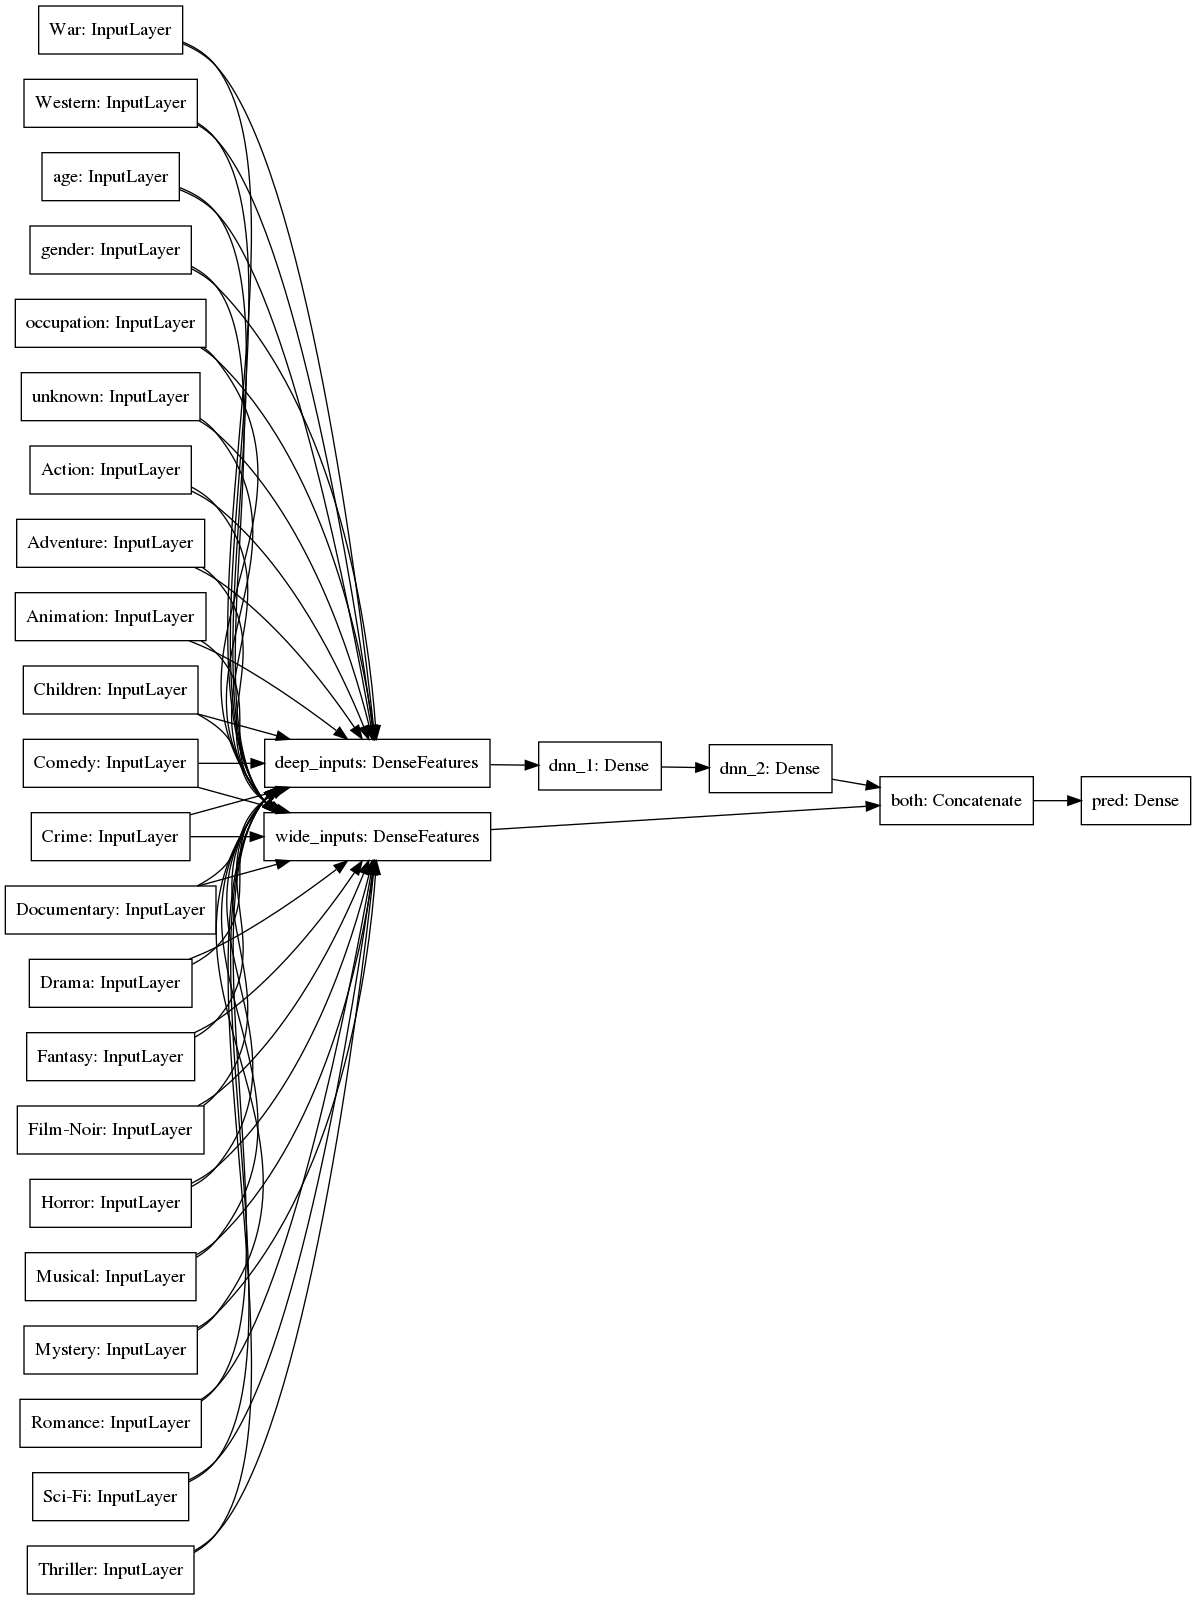

In [18]:
tf.keras.utils.plot_model(model, 'deep_and_wide_model.png', show_shapes=False, rankdir='LR')

In [19]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [21]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10, 
                    steps_per_epoch=50,
                    callbacks = [tensorboard_callback]
                   )

Epoch 1/10
50/50 [==============================] - 3s 68ms/step - loss: 0.5178 - accuracy: 0.7975 - val_loss: 0.5630 - val_accuracy: 0.7659
Epoch 2/10
50/50 [==============================] - 1s 24ms/step - loss: 0.5123 - accuracy: 0.7944 - val_loss: 0.5491 - val_accuracy: 0.7659
Epoch 3/10
50/50 [==============================] - 1s 27ms/step - loss: 0.5175 - accuracy: 0.7925 - val_loss: 0.5467 - val_accuracy: 0.7659
Epoch 4/10
50/50 [==============================] - 1s 24ms/step - loss: 0.5161 - accuracy: 0.7937 - val_loss: 0.5510 - val_accuracy: 0.7659
Epoch 5/10
50/50 [==============================] - 1s 28ms/step - loss: 0.5329 - accuracy: 0.7825 - val_loss: 0.5571 - val_accuracy: 0.7659
Epoch 6/10
50/50 [==============================] - 1s 26ms/step - loss: 0.5161 - accuracy: 0.7894 - val_loss: 0.5499 - val_accuracy: 0.7659
Epoch 7/10
50/50 [==============================] - 1s 25ms/step - loss: 0.5252 - accuracy: 0.7831 - val_loss: 0.5461 - val_accuracy: 0.7659
Epoch 8/10
50

In [22]:
#!tensorboard --logdir logs/fit

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C
